# PREDICTING SALES

The dataset we are going to use is taken from the competition, that serves as the final project for this course. You can find complete data description at the [competition web page](https://www.kaggle.com/c/competitive-data-science-final-project/data). To join the competition use [this link](https://www.kaggle.com/t/1ea93815dca248e99221df42ebde3540).


___

# MODULES


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


from grader import Week1_Grader
from grader import Week3_Grader
from grader import Week4_Grader

%matplotlib inline
week1_grader = Week1_Grader()
week3_grader = Week3_Grader()
week4_grader = Week4_Grader()


In [2]:
def downcast_dtypes(df):
    '''
    int8:      -127 to 128
    int16: -32.7k to 32.7k
    int32:   -2.1B to 2.1B
    int64: all the numbers
    '''
    
    df_copy = df.copy(deep=True)
    # Select columns to downcast
    float_to32_cols = [c for c in df_copy if df_copy[c].dtype == "float64"]
    int_to32_cols =   [c for c in df_copy if df_copy[c].dtype == "int64"]
    
    # Downcast
    #df_copy[float_to32_cols] = df_copy[float_to32_cols].astype(np.float32)
    df_copy[int_to32_cols]   = df_copy[int_to32_cols].astype(np.int32)
    
    return df_copy
    

___

# DATA
## Load Data

In [3]:
DATA_FOLDER = './data/'

transactions_raw = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items            = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories  = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops            = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))


## Table Content

In [4]:
# shapes
print('transactions shape: {}'.format(transactions_raw.shape))
print('items shape: {}'.format(items.shape))
print('item_categories shape: {}'.format(item_categories.shape))
print('shops shape: {}'.format(shops.shape))


transactions shape: (2935849, 6)
items shape: (22170, 3)
item_categories shape: (84, 2)
shops shape: (60, 2)


In [5]:
# content 
display(transactions_raw.head(3))
display(items.head(3))
display(item_categories.head(3))
display(shops.head(3))


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


## Add new fields to the Transactions table

We add date information and revenue per item per shop per day.

_Note: the values of date_block_num are consecutive month numbers used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33._


In [6]:
# deep copy
transactions = transactions_raw.copy(deep=True)

# add date fields
transactions['date'] = pd.to_datetime(transactions['date'], format='%d.%m.%Y')
transactions['year'] = transactions['date'].dt.year
transactions['month'] = transactions['date'].dt.month
transactions['day'] = transactions['date'].dt.day

# add revenues
transactions['revenue_day'] = transactions['item_price'] * transactions['item_cnt_day']

# add item category
transactions = transactions.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')

# reorganize columns for legibility
transactions = transactions[[
    'date', 'date_block_num', 'year', 'month', 'day', 
    'shop_id', 'item_id', 'item_category_id', 'item_price', 'item_cnt_day', 'revenue_day']]

# donwcast dtypes
transactions = downcast_dtypes(transactions)

# check final table
transactions.head(3)


,date,date_block_num,year,month,day,shop_id,item_id,item_category_id,item_price,item_cnt_day,revenue_day
0,2013-01-02,0,2013,1,2,59,22154,37,999.0,1.0,999.0
1,2013-01-03,0,2013,1,3,25,2552,58,899.0,1.0,899.0
2,2013-01-05,0,2013,1,5,25,2552,58,899.0,-1.0,-899.0


___

# WEEK 1 - EDA
v1.0.3

## Questions

1. ** What was the maximum total revenue among all the shops in September, 2014?** 


In [7]:
# revenues for sept. 2014
monthly_revenue_2014_09 = (
    transactions
    .loc[(transactions['year']==2014) & (transactions['month']==9)]
    .groupby('shop_id')['revenue_day']
    .agg('sum')   
)

# max revenue
max_revenue = monthly_revenue_2014_09.max()
week1_grader.submit_tag('max_revenue', max_revenue)


Current answer for task max_revenue is: 7982852.199999956


**2. What item category generated the highest revenue in summer 2014?**

In [8]:
# revenues for summer of 2014
category_revenue_2014_summer = (
    transactions
    .loc[(transactions['year']==2014) & (transactions['month'].isin([6,7,8]))]
    .groupby('item_category_id')['revenue_day']
    .agg('sum')
)

# item category with most revenue
category_id_with_max_revenue = category_revenue_2014_summer.idxmax()
week1_grader.submit_tag('category_id_with_max_revenue', category_id_with_max_revenue)


Current answer for task category_id_with_max_revenue is: 20


**3. How many items have constant prices during the whole period of time?**

We assume that the items are returned for the same price as they had been sold.


In [9]:
# item prices
prices_per_item = transactions.groupby('item_id')['item_price'].nunique()

# items with only one price
num_items_constant_price = prices_per_item[prices_per_item == 1].shape[0]
week1_grader.submit_tag('num_items_constant_price', num_items_constant_price)


Current answer for task num_items_constant_price is: 5926


**4. What was the unbiased variance of the number of sold items per day sequence for `shop_id = 25` in December, 2014?**

* Do not count the items that were sold but returned back later.
* If there were no sales at a given day, ***do not*** impute missing value with zero, just ignore that day.
* Compute the [unbiased variance](https://math.stackexchange.com/questions/496627/the-difference-between-unbiased-biased-estimator-variance) using `ddof=1`.


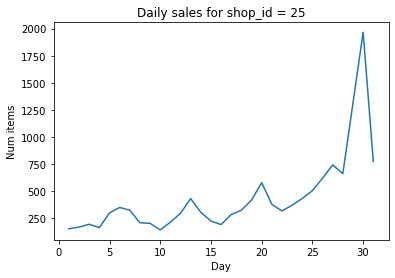

Current answer for task total_num_items_sold_var is: 117167.70229885059


In [10]:

# number of items sold per day in shop 25 during december 2014 
shop_id = 25
total_num_items_sold = (
    transactions
    .loc[(transactions['shop_id'] == shop_id) & 
         (transactions['year'] == 2014) & 
         (transactions['month'] == 12)
    ]
    .groupby('day')['item_cnt_day']
    .agg('sum')
)

# days when the shop was open
days = total_num_items_sold.index

# plot sales
plt.plot(days, total_num_items_sold)
plt.ylabel('Num items')
plt.xlabel('Day')
plt.title("Daily sales for shop_id = 25")
plt.show()

# unbiased variance
total_num_items_sold_var = np.var(total_num_items_sold, ddof=1)
week1_grader.submit_tag('total_num_items_sold_var', total_num_items_sold_var)


## Submit answers to Coursera

In [11]:
STUDENT_EMAIL = 'plat.sebastien@hotmail.fr'
STUDENT_TOKEN = '3qq5YjrDWosAySaj'
week1_grader.status()
week1_grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)


You want to submit these numbers:
Task max_revenue: 7982852.199999956
Task category_id_with_max_revenue: 20
Task num_items_constant_price: 5926
Task total_num_items_sold_var: 117167.70229885059
Submitted to Coursera platform. See results on assignment page!


___

# WEEK 3 - MEAN ENCODING
Version 1.1.0

## Aggregate Data

Since the competition task is to make a monthly prediction, we need to aggregate the data to montly level before doing any encodings.


In [ ]:
# columns for which to create a unique key (date_block_num is the month number)
index_cols = ['date_block_num', 'shop_id', 'item_id']


In [ ]:
# unique shops & items per month
shops = sales[['date_block_num', 'shop_id']].drop_duplicates()
items = sales[['date_block_num', 'item_id']].drop_duplicates()
 
# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = shops.loc[shops['date_block_num'] == block_num, 'shop_id']
    cur_items = items.loc[items['date_block_num'] == block_num, 'item_id']
    cur_items_shops = list(product(*[[block_num], cur_shops, cur_items]))
    grid += cur_items_shops


# convert to dataframe
grid = pd.DataFrame(np.array(grid), columns = index_cols, dtype=np.int32) 


In [ ]:
# get aggregated sales for (shop_id, item_id, month)
monthly_sales = (sales
    .groupby(index_cols, as_index=False)
    .agg({'item_cnt_day':'sum'})
    .rename(columns={'item_cnt_day': 'target'})
)

# join aggregated data to the grid
all_data = pd.merge(grid, monthly_sales, how='left', on=index_cols).fillna(0)

# sort the data
all_data.sort_values(index_cols,inplace=True)
all_data.head()


In [ ]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales[sales['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales[sales['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})

#fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
#join aggregated data to the grid
all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)
#sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)
all_data.head()


In [ ]:
'global mean: {:.4f}'.format(all_data['target'].mean())
